# 9章　多値分類

In [1]:
%matplotlib inline

# 日本語化ライブラリ導入
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=0a2bfeb30a59408f17316478a15b38f3d1c9cc00dacb518d8afe03155fa42679
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [2]:
# 必要ライブラリの宣言
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  Numpy変数print時の小数点表示を2桁に設定
np.set_printoptions(
    suppress=True, precision=2, floatmode='fixed'
)

# matplotlib日本語化対応
import japanize_matplotlib

### データ読み込み

In [3]:
# 学習用データ準備
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target

# 入力データに関しては、sepal length(0)とpetal length(2)のみ抽出
x_select = x_org[:,[0,2]]
print('元データ', x_select.shape, y_org.shape)

元データ (150, 2) (150,)


### 学習データの散布図表示

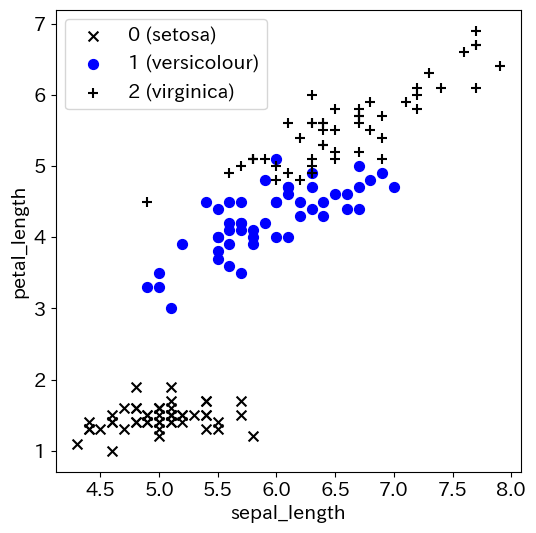

In [4]:
# 散布図の表示
x_t0 = x_select[y_org == 0]
x_t1 = x_select[y_org == 1]
x_t2 = x_select[y_org == 2]
plt.figure(figsize=(6,6))
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,1], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('petal_length', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=14)
plt.show()

### データ前処理

In [ ]:
# ダミー変数を追加
x_all = np.insert(x_select, 0, 1.0, axis=1)

In [ ]:
# yをOne-hot-Vectorに
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False,categories='auto')
y_work = np.c_[y_org]
y_all_one = ohe.fit_transform(y_work)
print('オリジナル', y_org.shape)
print('２次元化', y_work.shape)
print('One Hot Vector化後', y_all_one.shape)

In [ ]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape,
    y_train_one.shape, y_test_one.shape)

In [ ]:
print('入力データ(x)')
print(x_train[:5,:])

In [ ]:
print('正解データ(y)')
print(y_train[:5])

In [ ]:
print('正解データ (One Hot Vector化後)')
print(y_train_one[:5,:])

### 学習用変数の設定

In [ ]:
# 学習対象の選択
x, yt  = x_train, y_train_one

### 予測関数

In [ ]:
# softmax関数 (9.7.3)
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [ ]:
# 予測値の計算 (9.7.1, 9.7.2)
def pred(x, W):
    return softmax(x @ W)

### 評価

In [ ]:
# 交差エントロピー関数)(9.5.1)
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [ ]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):

    # 予測値の計算(確率値)
    yp_test_one = pred(x_test, W)

    # 確率値から予測クラス(0, 1, 2)を導出
    yp_test = np.argmax(yp_test_one, axis=1)

    # 損失関数値の計算
    loss = cross_entropy(y_test_one, yp_test_one)

    # 精度の算出
    score = accuracy_score(y_test, yp_test)
    return loss, score

### 初期化処理

In [ ]:
# 初期化処理

# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N))

# 評価結果記録用
history = np.zeros((0, 3))

### メイン処理

In [ ]:
#  メイン処理
for k in range(iters):

    # 予測値の計算 (9.7.1)　(9.7.2)
    yp = pred(x, W)

    # 誤差の計算 (9.7.4)
    yd = yp - yt

    # 重みの更新 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history,
            np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f"
            % (k, loss, score))

### 結果確認

In [ ]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f'
    % (history[0,1], history[0,2]))
print('最終状態: 損失関数:%f 精度:%f'
    % (history[-1,1], history[-1,2]))

In [ ]:
# 学習曲線の表示 (損失関数)
plt.plot(history[:,0], history[:,1])
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

In [ ]:
# 学習曲線の表示 (精度)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

In [ ]:
# 3次元表示
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 8.5, 100)
x2 = np.linspace(0.5, 7.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.array([np.ones(xx1.ravel().shape),
    xx1.ravel(), xx2.ravel()]).T
pp = pred(xxx, W)
c0 = pp[:,0].reshape(xx1.shape)
c1 = pp[:,1].reshape(xx1.shape)
c2 = pp[:,2].reshape(xx1.shape)
plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c0, color='lightblue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c1, color='blue',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.plot_surface(xx1, xx2, c2, color='lightgrey',
    edgecolor='black', rstride=10, cstride=10, alpha=0.7)
ax.scatter(x_t0[:,0], x_t0[:,1], 1, s=50, alpha=1, marker='+', c='k')
ax.scatter(x_t1[:,0], x_t1[:,1], 1, s=30, alpha=1, marker='o', c='k')
ax.scatter(x_t2[:,0], x_t2[:,1], 1, s=50, alpha=1, marker='x', c='k')
ax.set_xlim(4,8.5)
ax.set_ylim(0.5,7.5)
ax.view_init(elev=40, azim=70)

In [ ]:
# 評価
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# テストデータで予測値の計算
yp_test_one = pred(x_test, W)
yp_test = np.argmax(yp_test_one, axis=1)

#  精度の計算
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, yp_test)
print('accuracy: %f' % score)

# 混同行列の表示
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, yp_test))
print(classification_report(y_test, yp_test))

# 入力変数を4次元に変更

In [ ]:
# ダミー変数を追加
x_all2 = np.insert(x_org, 0, 1.0, axis=1)

In [ ]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train2, x_test2, y_train, y_test,\
y_train_one, y_test_one = train_test_split(
    x_all2, y_org, y_all_one, train_size=75,
    test_size=75, random_state=123)
print(x_train2.shape, x_test2.shape,
    y_train.shape, y_test.shape,
    y_train_one.shape, y_test_one.shape)

In [ ]:
print('入力データ(x)')
print(x_train2[:5,:])

In [ ]:
# 学習対象の選択
x, yt, x_test  = x_train2, y_train_one, x_test2

In [ ]:
# 初期化処理

# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む
D = x.shape[1]
# 分類先クラス数
N = yt.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 重み行列の初期設定(すべて1)
W = np.ones((D, N))

# 評価結果記録用
history = np.zeros((0, 3))

In [ ]:
#  メイン処理(４次元版)
for k in range(iters):

    # 予測値の計算 (9.7.1)　(9.7.2)
    yp = pred(x, W)

    # 誤差の計算 (9.7.4)
    yd = yp - yt

    # 重みの更新 (9.7.5)
    W = W - alpha * (x.T @ yd) / M

    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, y_test_one, W)
        history = np.vstack((history, np.array([k, loss, score])))
        print("epoch = %d loss = %f score = %f" % (k, loss, score))

In [ ]:
print(history.shape)

In [ ]:
#損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f'
    % (history[0,1], history[0,2]))
print('最終状態: 損失関数:%f 精度:%f'
    % (history[-1,1], history[-1,2]))

In [ ]:
# 学習曲線の表示 (損失関数)
plt.plot(history[:,0], history[:,1])
plt.ylim(0,1.2)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('iter vs loss', fontsize=14)
plt.show()

In [ ]:
# 学習曲線の表示 (精度)
plt.plot(history[:,0], history[:,2])
plt.ylim(0,1)
plt.grid()
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()